In [1]:
import numpy as np
import tensorflow as tf

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# UNET-R(architecture)

In [2]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from math import log2
import tensorflow as tf
import keras.layers as L
from keras.models import Model

# mlp = multilayer-perception
def mlp(x, cf): #x = input , cf = configuration files(dictionary[hyper parameters])
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

# Transformer encoder
def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1]) # Adding skip_1 & o/p of MultiheadAttention(residual block)

    # The above o/p 'x' act as skip_2

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2]) # we done same process and added(reidual block)

    return x

# Convolution decoder
def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x) # Conv2DTranspose = tries to inc height & width of image
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 768)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"]//cf["patch_size"],
        cf["image_size"]//cf["patch_size"],
        cf["hidden_dim"]
    )
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        # print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    ## Decoder 1
    x = deconv_block(z12, 128)

    s = deconv_block(z9, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])

    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 2
    x = deconv_block(x, 64)

    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    ## Decoder 3
    x = deconv_block(x, 32)

    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    ## Decoder 4
    x = deconv_block(x, 16)

    s = conv_block(z0, 16)
    s = conv_block(s, 16)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 16)
    x = conv_block(x, 16)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")

if __name__ == "__main__":
    config = {}
    config["image_size"] = 512
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["patch_size"] = 16
    config["num_patches"] = (config["image_size"]**2)//(config["patch_size"]**2)
    config["num_channels"] = 3

    model = build_unetr_2d(config)
    model.summary()


Model: "UNETR_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1024, 768)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1024, 768)         │         590,592 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1024, 768)         │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 1024, 768)         │           1,536 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 1024, 768)         │      28,339,968 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 1024, 768)         │               0 │ multi_head_attention[0][0… │
│                               │                           │                 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 1024, 768)         │           1,536 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1024, 3072)        │       2,362,368 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 1024, 3072)        │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1024, 768)         │       2,360,064 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 1024, 768)         │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 1024, 768)         │               0 │ dropout_2[0][0],           │
│                               │                           │                 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 1024, 768)         │           1,536 │ add_2[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 1024, 768)         │      28,339,968 │ layer_normalization_2[0][… │
│ (MultiHeadAttention)          │                           │               

 Total params: 399,369,201 (1.49 GB)

 Trainable params: 399,367,473 (1.49 GB)

 Non-trainable params: 1,728 (6.75 KB)

# Train

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify
#from unetr_2d import build_unetr_2d
#from metrics import dice_loss, dice_coef

""" UNETR  Configration """
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"], 
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
import os
from glob import glob
from sklearn.model_selection import train_test_split

def load_dataset(path,train_split = 0.7, validation_split=0.1, test_split=0.2):
    """ Loading the images and masks """
    X = sorted(glob(os.path.join(path, "augmented_images", "*.png")))
    Y = sorted(glob(os.path.join(path, "augmented_masks", "*.png")))

    total_samples = len(X)

    # Determine the number of samples for validation and testing
    validation_size = int(total_samples * validation_split)
    test_size = int(total_samples * test_split)

    # Train/Test Split
    # This results in test_size being the testing set, and the rest as the training+validation set
    train_x, test_x = train_test_split(X, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(Y, test_size=test_size, random_state=42)

    # Split the training set into the new training set and validation set
    train_x, valid_x = train_test_split(train_x, test_size=validation_size, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=validation_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0

    """ Processing to patches """
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32) 

    return patches

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(cf["flat_patches_shape"])
    y.set_shape([cf["image_size"], cf["image_size"], 1])
    return x, y

#This function is asynchronouysly fetching images and preprocessing images
def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 8
    lr = 0.01
    num_epochs = 100
    model_path = os.path.join("/kaggle/working/files", "model.keras")
    csv_path = os.path.join("/kaggle/working/files", "log.csv") 

    """ Dataset """
    dataset_path = "/kaggle/working/files/"
    (train_x, train_y), (val_x, val_y), (test_x, test_y) = load_dataset(dataset_path, 0.7, 0.2, 0.1)

    print(f"Train: {len(train_x)} images")
    print(f"Validation: {len(val_x)} images")
    print(f"Test: {len(test_x)} images")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    val_dataset = tf_dataset(val_x, val_y, batch=batch_size)

    """ Model """
    model = build_unetr_2d(cf)
    model.compile(loss=dice_loss, optimizer=SGD(lr), metrics=[dice_coef, "accuracy"])
    
    callbacks = [
        ModelCheckpoint(
            model_path,
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            verbose=1,
        ),
        CSVLogger(csv_path),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False)
    ]

    """ Model training """
    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )

# Test

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import tensorflow as tf
from patchify import patchify
import matplotlib.pyplot as plt

""" UNETR Configuration """
cf = {
    "image_size": 256,
    "num_channels": 3,
    "num_layers": 12,
    "hidden_dim": 128,
    "mlp_dim": 32,
    "num_heads": 6,
    "dropout_rate": 0.1,
    "patch_size": 16,
    "num_patches": (256 ** 2) // (16 ** 2),
    "flat_patches_shape": ((256 ** 2) // (16 ** 2), 16 * 16 * 3),
}

""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Create a directory if it doesn't exist """
os.makedirs("results", exist_ok=True)

""" Custom objects for loading the model """
def dice_loss(y_true, y_pred):
    # Your dice loss implementation
    pass

def dice_coef(y_true, y_pred):
    # Your dice coefficient implementation
    pass

""" Load the model """
model_path = (r"C:\Users\Lokesh\OneDrive\Desktop\neurology\model\file\model.keras")
model = tf.keras.models.load_model(
    model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef}
)

""" Specify the image path """
n = input("Enter the number of the image: ")
image_path = f"C:\python code\Brain-tumour-segmentation\images/{n}.png"


""" Check if the image exists """
if not os.path.exists(image_path):
    print(f"Image path '{image_path}' does not exist.")
    exit(1)

""" Read the image """
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if image is None:
    print("Failed to read the image.")
    exit(1)

""" Display the image with matplotlib """
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.show()

image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
x = image / 255.0

patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
patches = patchify(x, patch_shape, cf["patch_size"])
patches = np.reshape(patches, cf["flat_patches_shape"])
patches = patches.astype(np.float32)
patches = np.expand_dims(patches, axis=0)

""" Define a prediction function using tf.function to avoid retracing """
@tf.function(reduce_retracing=True)
def predict_patches(model, patches):
    return model(patches, training=False)

""" Prediction """
pred = predict_patches(model, patches)[0]
pred = np.concatenate([pred, pred, pred], axis=-1)

""" Save final mask """
save_image_path = f"results/{n}_prediction.png"
cv2.imwrite(save_image_path, pred * 255)

""" Display the final image with matplotlib """
saved_image = cv2.imread(save_image_path, cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(saved_image, cv2.COLOR_BGR2RGB))
plt.title("Tumor Mask")
plt.show()


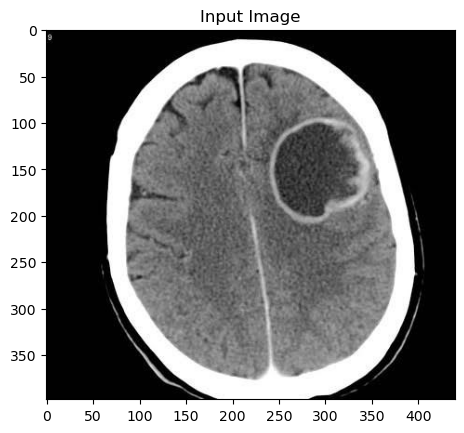

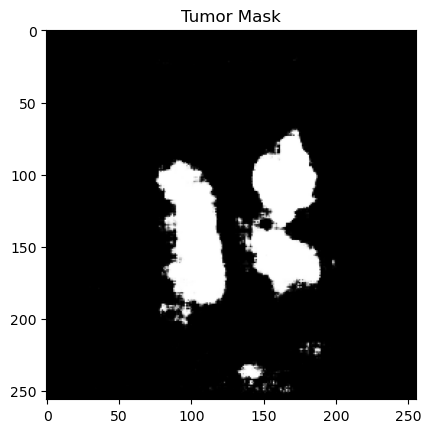

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import tensorflow as tf
from patchify import patchify
import matplotlib.pyplot as plt

""" UNETR Configuration """
cf = {
    "image_size": 256,
    "num_channels": 3,
    "num_layers": 12,
    "hidden_dim": 128,
    "mlp_dim": 32,
    "num_heads": 6,
    "dropout_rate": 0.1,
    "patch_size": 16,
    "num_patches": (256 ** 2) // (16 ** 2),
    "flat_patches_shape": ((256 ** 2) // (16 ** 2), 16 * 16 * 3),
}

""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Create a directory if it doesn't exist """
os.makedirs("results", exist_ok=True)

""" Custom objects for loading the model """
def dice_loss(y_true, y_pred):
    # Your dice loss implementation
    pass

def dice_coef(y_true, y_pred):
    # Your dice coefficient implementation
    pass

""" Load the model """
model_path = (r"C:\Users\Lokesh\OneDrive\Desktop\neurology\model\file\model.keras")
model = tf.keras.models.load_model(
    model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef}
)

""" Specify the image path """
# n = input("Enter the number of the image: ")
# image_path = f"C:\python code\Brain-tumour-segmentation\images/{n}.png"
image_path = "C://Users//Lokesh//OneDrive//Desktop//img_classification//IC_DATASET//IC_DATASET//pred//pred//pred10.jpg"


""" Check if the image exists """
if not os.path.exists(image_path):
    print(f"Image path '{image_path}' does not exist.")
    exit(1)

""" Read the image """
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if image is None:
    print("Failed to read the image.")
    exit(1)

""" Display the image with matplotlib """
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.show()

image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
x = image / 255.0

patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
patches = patchify(x, patch_shape, cf["patch_size"])
patches = np.reshape(patches, cf["flat_patches_shape"])
patches = patches.astype(np.float32)
patches = np.expand_dims(patches, axis=0)

""" Define a prediction function using tf.function to avoid retracing """
@tf.function(reduce_retracing=True)
def predict_patches(model, patches):
    return model(patches, training=False)

""" Prediction """
pred = predict_patches(model, patches)[0]
pred = np.concatenate([pred, pred, pred], axis=-1)

""" Save final mask """
save_image_path = f"results/prediction.png"
cv2.imwrite(save_image_path, pred * 255)

""" Display the final image with matplotlib """
saved_image = cv2.imread(save_image_path, cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(saved_image, cv2.COLOR_BGR2RGB))
plt.title("Tumor Mask")
plt.show()


In [2]:
import numpy as np

def get_positional_encoding(max_seq_len, d_model):
    """
    Generates a positional encoding matrix.
    
    Parameters:
    max_seq_len (int): The maximum length of the sequence.[[[256]]]
    d_model (int): The dimensionality of the embeddings.[[[#768]]]
    
    Returns:
    np.ndarray: A matrix of shape (max_seq_len, d_model) containing the positional encodings.
    """
    positional_encoding = np.zeros((max_seq_len, d_model))

    for pos in range(max_seq_len):
        for i in range(0, d_model, 2):
            positional_encoding[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            if i + 1 < d_model:
                positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
    
    return positional_encoding

# Example usage:
max_seq_len = 256  # maximum sequence length
d_model = 768      # embedding dimension

positional_encoding = get_positional_encoding(max_seq_len, d_model)
print(positional_encoding)


[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 8.41470985e-01  5.50294858e-01  8.28430762e-01 ...  9.99999995e-01
   1.02427522e-04  9.99999995e-01]
 [ 9.09297427e-01 -3.94351139e-01  9.27994032e-01 ...  9.99999979e-01
   2.04855043e-04  9.99999980e-01]
 ...
 [ 9.94823729e-01  2.25415602e-01  9.25326051e-01 ...  9.99656097e-01
   2.59112628e-02  9.99672204e-01]
 [ 4.51998898e-01  9.37525562e-01  2.04149173e-01 ...  9.99653373e-01
   2.60136558e-02  9.99669607e-01]
 [-5.06391635e-01  8.06415390e-01 -6.96641624e-01 ...  9.99650638e-01
   2.61160485e-02  9.99667001e-01]]


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding

# Define the configuration
cf = {
    "num_patches": 10,  # number of positions
    "hidden_dim": 16    # dimensionality of embeddings
}

# Generate a range of positions
positions = tf.range(start=0, limit=cf["num_patches"], delta=1)

# Create an embedding layer
embedding_layer = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])

# Get the positional embeddings
pos_embed = embedding_layer(positions)

# Print the positional embeddings
print(pos_embed.numpy())


[[-0.02829098 -0.00440864  0.02241908 -0.03650297  0.04929382  0.02168292
   0.02359972  0.00925776  0.01585194 -0.00215515 -0.01041024 -0.02797516
  -0.03587499  0.03085769  0.04554354  0.01905279]
 [ 0.03734726 -0.046709    0.01048654  0.00109731 -0.01078467 -0.00858544
   0.0010904  -0.04911056  0.00285489  0.03497208 -0.02757608 -0.01457831
  -0.00429472 -0.02022299 -0.02763578  0.01626796]
 [-0.01742741 -0.03112925 -0.04869818 -0.01726763  0.01110461  0.02043592
  -0.02393475 -0.02872798  0.04337258 -0.01222049  0.04951933  0.03074923
   0.00642072  0.0278114  -0.01759361 -0.02148436]
 [ 0.02604873  0.01376993  0.04207278  0.03724818 -0.04571878  0.03249845
   0.04733931  0.01797166 -0.00146444  0.03623525  0.00877091  0.03126341
  -0.01084178  0.0401277   0.03894867  0.01136613]
 [-0.01325592  0.0104747  -0.03783854  0.04555508 -0.00193894 -0.04194647
  -0.01012618  0.02056934 -0.02018162 -0.03426874  0.01999808 -0.03526338
   0.04593929  0.01175768 -0.00685753 -0.01765867]
 [ 0.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the input vector (batch of vectors)
batch_size = 2
seq_len = 5
d_model = 16

# Example input tensor
input_tensor = Input(shape=(seq_len, d_model))

# Define dense layers for query, key, and value
Wq = Dense(d_model)
Wk = Dense(d_model)
Wv = Dense(d_model)

# Apply dense layers to generate queries, keys, and values
query = Wq(input_tensor)
key = Wk(input_tensor)
value = Wv(input_tensor)

# Define a model to encapsulate the layers
model = Model(inputs=input_tensor, outputs=[query, key, value])

# Create some example input data
import numpy as np
example_input = np.random.randn(batch_size, seq_len, d_model).astype(np.float32)

# Get the query, key, and value matrices
query_matrix, key_matrix, value_matrix = model.predict(example_input)

print("Query matrix shape:", query_matrix.shape)
print("Key matrix shape:", key_matrix.shape)
print("Value matrix shape:", value_matrix.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Query matrix shape: (2, 5, 16)
Key matrix shape: (2, 5, 16)
Value matrix shape: (2, 5, 16)
